In [2]:
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt
import random
import math

In [95]:
def load_dataset(month="2020年6月", date=20200613, grouped=True):
    root_path = "/Users/liyurun/Downloads/OneDrive_1_11-18-2020/提供データ/配達実績/" + month + ".xls"
    original = pd.read_excel(root_path)

    # 指定した日付のみを抽出
    data = original[original["完了日付"] == date]
    data = data.drop(["完了日付"], axis=1)

    # 緯度・経度情報を統合
    data_0 = data[data["緯度＿完了優先"] == 0]
    data_0["緯度"] = data_0["緯度＿住所より"]
    data_0["経度"] = data_0["経度＿住所より"]

    data_1 = data[data["緯度＿完了優先"] != 0]
    data_1["緯度"] = data_1["緯度＿完了優先"]
    data_1["経度"] = data_1["経度＿完了優先"]

    data = pd.concat([data_0, data_1], axis=0)

    # コード0を削除
    data = data[data["配達乗務員\nコード"] != 0]

    # 必要なcolumnのみ抽出
    col = ["配達乗務員\nコード", "完了時刻", "緯度", "経度", "個数", "重量","配達予定時刻"]
    data = data[col]

    # ソート
    data = data.sort_values(["配達乗務員\nコード", "完了時刻"])
    data.reset_index(drop=True, inplace=True)

    # 緯度・経度に関して重複する部分をグループ化する場合
    if grouped:
        _data = pd.DataFrame()
        for driver_id in get_id_list(data):
            data_per_driver = data[data["配達乗務員\nコード"] == driver_id]
            data_per_driver = grouped_duplicate(data_per_driver)
            _data = _data.append(data_per_driver, ignore_index=True)
        data = _data
        data.reset_index(drop=True, inplace=True)

    return data


# 緯度・経度に関して重複する部分をグループ化
def grouped_duplicate(data):
    # 緯度・経度が同じものに関してグループ化
    df_1 = data.groupby(["緯度", "経度"]).max()  # df_1:グループの中の最大値を取得
    df_2 = data.groupby(["緯度", "経度"]).min()  # df_2:グループの中の最小値を取得
    df_3 = data.groupby(["緯度", "経度"]).sum()  # df_3:グループの中の総和を取得

    df_1 = df_1[["配達乗務員\nコード", "完了時刻"]]
    df_2 = df_2[["完了時刻"]].rename(columns={"完了時刻": "1st完了時刻"})
    df_3 = df_3[["個数", "重量"]]

    # 結合
    df = pd.concat([df_1, df_2, df_3], axis=1)

    # 緯度・経度がindexに入ってるためcolumnへ
    df["緯度"] = [df.index[i][0] for i in range(len(df.index))]
    df["経度"] = [df.index[i][1] for i in range(len(df.index))]

    # 順序を入れ替える
    df = df[["配達乗務員\nコード", "1st完了時刻", "完了時刻", "緯度", "経度", "個数", "重量"]]
    df = df.sort_values("完了時刻")
    df.reset_index(drop=True, inplace=True)

    return df


# dataに含まれるドライバーのIDを取得
def get_id_list(data):
    data_grouped = data.groupby("配達乗務員\nコード")
    id_list = list(data_grouped.size().index)
    return id_list


# データから指定したIDのドライバー1人のデータを取得
def get_data_per_driver(data, driver_id):
    data_per_driver = data[data["配達乗務員\nコード"] == driver_id]
    data_per_driver.reset_index(drop=True, inplace=True)
    return data_per_driver

In [ ]:
data = load_dataset()

In [83]:
df = grouped_duplicate(data)
ID = get_id_list(data)

In [98]:
data

,配達乗務員\nコード,1st完了時刻,完了時刻,緯度,経度,個数,重量
0,24089,1029,1029,35.114228,136.640980,42,309
1,24089,1042,1042,35.112731,136.639003,9,74
2,24089,1107,1107,35.033508,136.615065,11,120
3,24089,1107,1107,35.107506,136.635094,27,499
4,24089,1119,1119,35.100322,136.634881,1,65
...,...,...,...,...,...,...,...
430,861633,1041,1041,35.354790,136.627796,1,20
431,861633,1044,1044,35.353780,136.628317,2,20
432,861633,1114,1114,35.361501,136.626259,41,1005
433,861633,1129,1129,35.362901,136.624016,2,29


In [9]:
df = grouped_duplicate(data)
driver_id = get_id_list(data)
driver_data = get_data_per_driver(data,driver_id[0])

In [13]:
lat = driver_data['緯度'].tolist()
lon = driver_data['経度'].tolist()
cityList = []
for i in range(len(lat)):
    cityList.append(City(x=lat[i], y=lon[i]))
cityList

[(35.1142283,136.6409799),
 (35.1127311,136.6390029),
 (35.0335084,136.6150655),
 (35.1075064,136.6350935),
 (35.1003225,136.6348807)]

In [10]:
class City(object):

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance

def cal_dis(lat1, lon1, lat2, lon2):
    lat1 = (math.pi / 180) * lat1
    lat2 = (math.pi / 180) * lat2
    lon1 = (math.pi / 180) * lon1
    lon2 = (math.pi / 180) * lon2

    R = 6378.137
    if (lat1 != lat2) & (lon1 != lon2) :
        d = math.acos(math.sin(lat1) * math.sin(lat2) + math.cos(lat1) * math.cos(lat2) * math.cos(lon2 - lon1)) * R * 1000
    else:
        d = 0
    return int(d)

class Fitness(object):
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness = 0.0

    def routeDistance(self):

        if self.distance == 0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None

                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]

                pathDistance += cal_dis(fromCity.x,fromCity.y,toCity.x,toCity.y)
            self.distance = pathDistance
        return self.distance

    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
            #print("Fitness: ", self.fitness)
        return self.fitness

def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

def rankRoutes(population):
    fitnessResults = {}

    for i in range(0, len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()

    return sorted(fitnessResults.items(), key=operator.itemgetter(1), reverse=True)


def selection(popRanked, eliteSize):
    selectionResults = []

    df = pd.DataFrame(np.array(popRanked), columns=["Index", "Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100 * df.cum_sum / df.Fitness.sum()

    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])

    for i in range(0, len(popRanked) - eliteSize):

        pick = 100 * random.random()

        for i in range(0, len(popRanked)):
            if pick <= df.iat[i, 3]:
                selectionResults.append(popRanked[i][0])
                break

    return selectionResults



def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool



def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []

    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))

    ## Inicio e fim do corte de cruzamento
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])

    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child


def breedPopulation(matingPool, eliteSize):
    children = []
    length = len(matingPool) - eliteSize
    pool = random.sample(matingPool, len(matingPool))

    for i in range(0, eliteSize):
        children.append(matingPool[i])

    for i in range(0, length):
        child = breed(pool[i], pool[len(matingPool) - i - 1])
        children.append(child)
    return children


def mutate(individual, mutationRate):
    for swapped in range(len(individual)):

        if (random.random() < mutationRate):

            swapWith = int(random.random() * len(individual))

            city1 = individual[swapped]
            city2 = individual[swapWith]

            individual[swapped] = city2
            individual[swapWith] = city1

    return individual


def mutatePopulation(population, mutationRate):
    mutatedPop = []

    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)

    return mutatedPop

def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)

    return nextGeneration

def ga(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    #print('##########start fitting########')
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))

    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)

    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute,int(1 / rankRoutes(pop)[0][1])

In [ ]:
oneRoute = ga(population=cityList, popSize=20, eliteSize=20, mutationRate = 0.01, generations=100)

In [18]:
def showMap(cityList):
    plt.cla()
    #print(cityList)
    prev=cityList[-1]
    for i in cityList:
        plt.plot(i.x, i.y,'ro')
        plt.plot(prev.x,prev.y, 'k-')
        if(prev.x == 0 and prev.y == 0):
            prev=i
            continue;
        else:
            plt.plot([prev.x,i.x],[prev.y, i.y],'k-')
            prev=i
    #plt.show()

In [17]:
#main
df = grouped_duplicate(data)
driver_id = get_id_list(data)

In [61]:
import time
dist=[0 for i in range(len(driver_id))]
ctime=[0 for i in range(len(driver_id))]
DISTANCE = [[] for i in range(len(driver_id))]
DISTANCE_NEW = [[] for i in range(len(driver_id))]
LAT=[[] for i in range(len(driver_id))]
LON=[[] for i in range(len(driver_id))]
LATNEW=[[] for i in range(len(driver_id))]
LONNEW=[[] for i in range(len(driver_id))]
ID = [[] for i in range(len(driver_id))]

##########start fitting########
Initial distance: 8314.0
Final distance: 7899.999999999999
3
driver ID :  26511
computation time :  0.9769878387451172
##########end fitting########
#############end No. 1 ###############
 
##########start fitting########
Initial distance: 256590.99999999997
Final distance: 252525.0
11
driver ID :  31727
computation time :  8.714823961257935
##########end fitting########
#############end No. 2 ###############
 
##########start fitting########
Initial distance: 14217.0
Final distance: 10964.0
11
driver ID :  54056
computation time :  4.511626958847046
##########end fitting########
#############end No. 3 ###############
 
##########start fitting########
Initial distance: 13424.0
Final distance: 7906.000000000001
11
driver ID :  55996
computation time :  7.952422142028809
##########end fitting########
#############end No. 4 ###############
 
##########start fitting########
Initial distance: 124708.0
Final distance: 116743.0
13
driver ID :  56267
computation

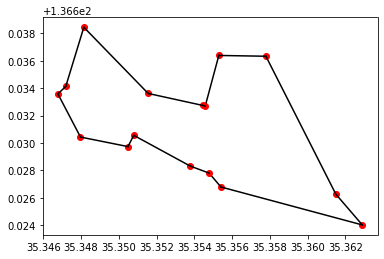

In [66]:
for num in range(1,38):
    print('##########start fitting########')

    driver_data = get_data_per_driver(data,driver_id[num])
    lat = driver_data['緯度'].tolist()
    lon = driver_data['経度'].tolist()
    cityList = []
    for i in range(len(lat)):
        cityList.append(City(x=lat[i], y=lon[i]))
    start = time.time()
    oneRoute,bestdistance = ga(population=cityList, popSize=len(lat)*4, eliteSize=len(lat), mutationRate = 0.01, generations=20*len(lat))
    end = time.time()

    plt.ion()
    showMap(oneRoute)
    plt.savefig('/Users/liyurun/Desktop/figure_20200125/' + str(driver_id[num]) + '.jpg')
    plt.ioff()
    dist[num] = bestdistance
    ctime[num] = end -start
    lat_new,lon_new = oneRoute_to_dis(oneRoute=oneRoute,cityList=cityList)
    for i in range(len(oneRoute)):
        ID[num].append(driver_id[num])
        LAT[num].append(lat[i])
        LON[num].append(lon[i])
        DISTANCE[num].append(cal_dis(lat[i],lon[i],lat[(i+1)%len(oneRoute)],lon[(i+1)%len(oneRoute)]))
        LATNEW[num].append(lat_new[i])
        LONNEW[num].append(lon_new[i])
        DISTANCE_NEW[num].append(cal_dis(lat_new[i],lon_new[i],lat_new[(i+1)%len(oneRoute)],lon_new[(i+1)%len(oneRoute)]))
    print('driver ID : ',driver_id[num])
    print('computation time : ',(end -start))
    print('##########end fitting########')
    print('#############end No.',num,'###############')
    print(' ')
      

In [72]:
IDLIST = []
LATLIST = []
LONLIST = []
LATNEWLIST = []
LONNEWLIST = []
DISTANCELIST = []
DISTANCE_NEWLIST = []
for i in range(len(ID)):
    IDLIST.extend(ID[i])
    LATLIST.extend(LAT[i])
    LONLIST.extend(LON[i])
    LATNEWLIST.extend(LATNEW[i])
    LONNEWLIST.extend(LONNEW[i])
    DISTANCELIST.extend(DISTANCE[i])
    DISTANCE_NEWLIST.extend(DISTANCE_NEW[i])
output = {"ID":IDLIST,
         "origin path[lat]":LATLIST,
         "origin path[lon]":LONLIST,
         "distance of i and i+1[origin]":DISTANCELIST,
         "optimized path[lat]":LATNEWLIST,
         "optimized path[lon]":LONNEWLIST,
         "distance of i and i+1[optimized]":DISTANCE_NEWLIST,
         }
df_output = pd.DataFrame(output)
df_output

,ID,origin path[lat],origin path[lon],distance of i and i+1[origin],optimized path[lat],optimized path[lon],distance of i and i+1[optimized]
0,24089,35.114228,136.640980,245,35.114228,136.640980,245
1,24089,35.112731,136.639003,9084,35.112731,136.639003,681
2,24089,35.033508,136.615065,8437,35.107506,136.635094,8437
3,24089,35.107506,136.635094,799,35.033508,136.615065,7653
4,24089,35.100322,136.634881,1644,35.100322,136.634881,1644
...,...,...,...,...,...,...,...
430,861633,35.354790,136.627796,122,35.354579,136.632689,16
431,861633,35.353780,136.628317,879,35.354441,136.632743,330
432,861633,35.361501,136.626259,256,35.351558,136.633614,580
433,861633,35.362901,136.624016,2100,35.348148,136.638449,406


In [73]:
df_output.to_csv("/Users/liyurun/Desktop/data_20210125/data.csv")

In [50]:
print('CityList:')
for i in cityList:
    print(i.x,i.y)
print('\noneRoute:')
for i in range(len(lat)):
    print(lat_new[i],lon_new[i])

CityList:
35.3537817 136.6055703
35.3550777 136.6069943
35.3596804 136.6041777
35.3604738 136.6073637
35.3644233 136.6153787
35.3625716 136.6172645
35.375565 136.6207
34.6797165 135.5338832
35.3666939 136.6185582
35.3667629 136.6179952
35.3661958 136.6178395
35.3663734 136.6194059
35.3648297 136.617386
35.3640365 136.6194888
35.3648526 136.6187082

oneRoute:
35.3537817 136.6055703
35.3550777 136.6069943
35.3625716 136.6172645
35.3640365 136.6194888
35.3648526 136.6187082
35.3663734 136.6194059
35.375565 136.6207
35.3666939 136.6185582
35.3667629 136.6179952
35.3661958 136.6178395
35.3648297 136.617386
35.3644233 136.6153787
35.3604738 136.6073637
35.3596804 136.6041777
34.6797165 135.5338832


In [57]:
def oneRoute_to_dis(oneRoute,cityList):
    lat_new = [i.x for i in oneRoute]
    lon_new = [i.y for i in oneRoute]
    lat = [i.x for i in cityList]
    lon = [i.y for i in cityList]
    lat_new_1 = [0 for i in oneRoute]
    lon_new_1 = [0 for i in oneRoute]
    
    for i in range(len(lat)):
        if lat_new[i] == lat[0]:
            print(i)
            temp = i
            break
    for i in range(len(lat)):
        lat_new_1[i] = lat_new[(i+temp)%len(lat)]
        lon_new_1[i] = lon_new[(i+temp)%len(lon)]
    return lat_new_1,lon_new_1

            

In [49]:
lat_new,lon_new = oneRoute_to_dis(oneRoute=oneRoute,cityList=cityList)

2


In [56]:
a=[]
for i in range(len(ID)):
    datadf = get_data_per_driver(df,ID[i])
    timelist

array([[ 35.3537817, 136.6055703],
       [ 35.3550777, 136.6069943],
       [ 35.3625716, 136.6172645],
       [ 35.3640365, 136.6194888],
       [ 35.3648526, 136.6187082],
       [ 35.3663734, 136.6194059],
       [ 35.375565 , 136.6207   ],
       [ 35.3666939, 136.6185582],
       [ 35.3667629, 136.6179952],
       [ 35.3661958, 136.6178395],
       [ 35.3648297, 136.617386 ],
       [ 35.3644233, 136.6153787],
       [ 35.3604738, 136.6073637],
       [ 35.3596804, 136.6041777],
       [ 34.6797165, 135.5338832]])

In [94]:
data.to_csv('/Users/liyurun/Desktop/data_set/data.csv')

In [119]:
np.savetxt("/Users/liyurun/Desktop/dist.csv",dist)
np.savetxt('/Users/liyurun/Desktop/ctime.csv',ctime)

In [3]:
df = pd.read_excel("/Users/liyurun/Desktop/data1.xlsx")

In [4]:
df.dropna(how='any',inplace=True)

In [19]:
DIST = []
for num in range(len(id_list)):
    driverdf = df[df["ID"]==id_list[num]]

    lat = driverdf['lat'].values
    lon = driverdf['lon'].values

    for i in range(len(lat)):
        DIST.append(cal_dis(lat[i],lon[i],lat[(i+1)%len(lat)],lon[(i+1)%len(lat)]))
    print("distance of id: {}".format(id_list[num]))


distance of id: 24089.0
distance of id: 26511.0
distance of id: 31727.0
distance of id: 54056.0
distance of id: 55996.0
distance of id: 56267.0
distance of id: 115430.0
distance of id: 131960.0
distance of id: 131970.0
distance of id: 131994.0
distance of id: 132060.0
distance of id: 152312.0
distance of id: 152412.0
distance of id: 156126.0
distance of id: 214147.0
distance of id: 214532.0
distance of id: 222657.0
distance of id: 222911.0
distance of id: 232125.0
distance of id: 232680.0
distance of id: 316632.0
distance of id: 512848.0
distance of id: 513108.0
distance of id: 531491.0
distance of id: 550730.0
distance of id: 612689.0
distance of id: 612752.0
distance of id: 612825.0
distance of id: 612842.0
distance of id: 621634.0
distance of id: 631083.0
distance of id: 651003.0
distance of id: 713350.0
distance of id: 714414.0
distance of id: 751669.0
distance of id: 752039.0
distance of id: 860870.0
distance of id: 861633.0


In [14]:
def cal_dis(lat1, lon1, lat2, lon2):
    lat1 = (math.pi / 180) * lat1
    lat2 = (math.pi / 180) * lat2
    lon1 = (math.pi / 180) * lon1
    lon2 = (math.pi / 180) * lon2

    R = 6378.137
    if (lat1 != lat2) & (lon1 != lon2) :
        d = math.acos(math.sin(lat1) * math.sin(lat2) + math.cos(lat1) * math.cos(lat2) * math.cos(lon2 - lon1)) * R * 1000
    else:
        d = 0
    return int(d)

In [28]:
df.to_csv('/Users/liyurun/Desktop/data2.csv')